# Advanced Programming Summative Assignment

Please see the README file (README.md) for a full overview of the project, installation instructions and running instructions. 

## Contents

#### 1.0 [Package installations and import statements](#1.0-Package-installations-and-import-statements)

#### 2.0 [Data extraction and cleaning](#2.0-Data-extraction-and-cleaning)

2.1 [Read CSVs to dataframes and general data cleaning](#2.2-Merge-airport-and-frequency-dataframes)

2.2 [Merge airport and frequency dataframes](#2.1-Read-CSVs-to-dataframes-and-general-data-cleaning)

2.3 [Transform dataframes to JSON](#2.3-Transform-dataframes-to-JSON)

#### 3.0 [3.0 Manage data functionality and GUI](#3.0-Manage-data-functionality-and-GUI)

3.1 [Load data and save data functions](#3.1-Load-data-and-save-data-functions)

3.2 [GUI manage data tab functions](#3.2-GUI-manage-data-tab-functions)

3.3 [GUI setup with manage data tab and help tab](#3.3-GUI-setup-with-manage-data-tab-and-help-tab)




### 1.0 Package installations and import statements

In [1]:
# Installing missing packages
# %conda install --yes --prefix {sys.prefix} numpy
# %conda install --yes --prefix {sys.prefix} pandas

In [20]:
# Import packages
import os
import path
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk
from tkinter import ttk
from tkinter.tix import *
from tkinter import messagebox

### 2.0 Data extraction and cleaning

A lot of the data processing is generic and not specific to the original data. This allows the application to handle other datasets from the same source. 

#### 2.1 Read CSVs to dataframes and general data cleaning

In [3]:
"""Load and clean data functions."""

def check_files():
    """Check that the three csv files exist in the correct folder with the correct names."""
    if (os.path.exists('data/runways.csv') and os.path.exists('data/airport-frequencies.csv') and os.path.exists('data/airports.csv')):
        return True
    else: 
        return False

def upload_date(): 
    """Extract data from CSV files and add to pandas dataframes."""
    try:
        df_runways = pd.read_csv ('data/runways.csv', index_col=['id'])
        df_frequencies = pd.read_csv ('data/airport-frequencies.csv', index_col=['id'])
        # Prevent pandas from replacing the 'continent' value 'NA' (for North America) with NaN 
        df_airports = pd.read_csv ('data/airports.csv', keep_default_na=False)
        return (df_runways, df_frequencies, df_airports)
    except: 
        messagebox.showwarning("Error", "There has been an error uploading the data. Please check the format of the csv files.")

# The following functions carry out generic data cleaning on the dataframes

def remove_missing_data(df_runways, df_frequencies, df_airports):
    """Remove any rows with all data missing."""
    df_airports.dropna(how='all')
    df_runways.dropna(how='all')
    df_frequencies.dropna(how='all')


def remove_duplicates(df_runways, df_frequencies, df_airports):
    """Remove any duplicated rows."""
    df_airports.drop_duplicates()
    df_runways.drop_duplicates()
    df_frequencies.drop_duplicates()


def remove_cols(df_runways, df_frequencies, df_airports):
    """Remove unneeded columns."""
    df_airports.drop(['keywords','home_link','local_code'], axis='columns', inplace=True)
    df_runways.drop(['airport_ident'], axis='columns', inplace=True)
    df_frequencies.drop(['airport_ident','description','type'], axis='columns', inplace=True)


def change_col_names(df_airports):
    """Change the airport column id name to airport_ref to align with other data."""
    df_airports.rename(columns={"id": "airport_ref"}, inplace=True)


def remove_invalid(df_runways, df_frequencies, df_airports):
    """Remove rows that do not have a valid airport_ref."""
    df_airports = df_airports[df_airports['airport_ref'].apply(lambda x: str(x).isdigit())]
    df_runways = df_runways[df_runways['airport_ref'].apply(lambda x: str(x).isdigit())]
    df_frequencies = df_frequencies[df_frequencies['airport_ref'].apply(lambda x: str(x).isdigit())]
    return (df_runways, df_frequencies, df_airports)


def add_new_cols(df_airports):
    """Add columns to the Airports df for small, medium and large airports with binary values."""
    df_airports['small_airport'] = df_airports.type == 'small_airport'
    df_airports['medium_airport'] = df_airports.type == 'medium_airport'
    df_airports['large_airport'] = df_airports.type == 'large_airport'
    df_airports['small_airport'] = df_airports['small_airport'].astype(int) 
    df_airports['medium_airport'] = df_airports['medium_airport'].astype(int) 
    df_airports['large_airport'] = df_airports['large_airport'].astype(int) 
    return(df_airports)


def remove_closed(df_airports):
    """Remove closed airports."""
    df_airports = df_airports[(df_airports.type != 'closed')]
    return(df_airports)


def load_new_data():
    """Call load data and data cleaning functions."""
    df_runways, df_frequencies, df_airports = upload_date()
    remove_missing_data(df_runways, df_frequencies, df_airports)
    remove_duplicates(df_runways, df_frequencies, df_airports)
    remove_cols(df_runways, df_frequencies, df_airports)
    change_col_names(df_airports)
    remove_invalid(df_runways, df_frequencies, df_airports)
    add_new_cols(df_airports)
    remove_closed(df_airports)
    return df_runways, df_frequencies, df_airports


#### 2.2 Merge airport and frequency dataframes

In [4]:
"""Merge airport and frequency dataframes into a single dataframe with one row per airport. Airports with multiple frequencies will have them stored in a list."""

def frequencies_to_list(df_frequencies):
    """Create a dictionary of airports each with a nested list of frequencies used by that airport."""
    # Initialise an empty dict to hold one key for each airport with a nested list of frequencies 
    frequencies_dict = {}

    # Iterate through the frequencies creating one key for each airport with a list for it's frequencies 
    for index, row in df_frequencies.iterrows():
        if row['airport_ref'] not in frequencies_dict:
            frequencies_dict[row['airport_ref']] = [row['frequency_mhz']]
        else:
            frequencies_dict[row['airport_ref']].append(row['frequency_mhz'])
    return frequencies_dict


def merge_dataframes(frequencies_dict, df_airports):
    """Merge the airports dataframe with the dictionary of airports with nested lists of frequencies."""
    # Create a pandas series of airports (as index) and frequency lists 
    df_frequencies_series = pd.Series(frequencies_dict, name='df_frequencies_series')
    # Rename the column titles to align with other data 
    df_airports_frequencies = df_frequencies_series.to_frame()
    df_airports_frequencies.index.name = 'airport_ref'
    # Convert to dataframe and merge with airports dataframe 
    df_airports_frequencies.rename(columns={'df_frequencies_series': 'frequency_mhz'}, inplace = True)
    df_airports_frequencies = pd.merge(df_airports, df_airports_frequencies, on="airport_ref", how = 'left')
    return df_airports_frequencies


def merge_airports_frequencies(df_frequencies, df_airports):
    """Call merge functions to merge airports with their communication frequencies."""
    frequencies_dict = frequencies_to_list(df_frequencies)
    df_airports_frequencies = merge_dataframes(frequencies_dict, df_airports)
    return df_airports_frequencies


#### 2.3 Transform dataframes to JSON

In [5]:
def transform_to_json(df_airports_frequencies, df_runways):
    """Translate dataframe data into JSON objects."""
    # write combined airport and frequency data to JSON
    airports_frequencies_json = df_airports_frequencies.to_json(orient = 'records')
    airports_frequencies_json_list = json.loads(airports_frequencies_json)
    # write runways data to JSON
    runways_json = df_runways.to_json(orient = 'records')
    runways_json_list = json.loads(runways_json)
    return airports_frequencies_json_list, runways_json_list


### 3.0 Manage data functionality and GUI

3.1 Load data and save data functions

In [6]:
def check_load_files():
    """Check that the previously saved files exist in the correct folder with the correct names."""
    if (os.path.exists('./saved-data/airports_frequencies.json') and os.path.exists('./saved-data/runways_json_list.json')):
        return True
    else:
        return False


def load_data():
    """Load previously saved data from JSON files in the 'saved-data' folder"""
    # Check that the files correctly exist in the 'save-data' folder and if not return False 
    try: 
        with open('./saved-data/airports_frequencies.json', 'r') as infile:
            loaded_airports_frequencies = json.load(infile)
        with open('./saved-data/runways_json_list.json', 'r') as infile:
            loaded_runways = json.load(infile)
        return loaded_airports_frequencies, loaded_runways
    except:
        messagebox.showwarning("Error", "There has been an error loading the saved data")


def save_data(airports_frequencies_json_list, runways_json_list):
    """Save current data to JSON files in the 'saved-data' folder."""
    try:
        with open('./saved-data/airports_frequencies.json', 'w') as outfile:
            json.dump(airports_frequencies_json_list, outfile)
        with open('./saved-data/runways_json_list.json', 'w') as outfile:
            json.dump(runways_json_list, outfile)
        messagebox.showinfo("Success", "Data has been saved")
    except:
        messagebox.showwarning("Error", "There has been an error saving the data")

3.2 GUI manage data tab functions

In [7]:
# Global variables are not recommended for the production application. However, for this prototype, which has to use Tkinter, there is no other option. With Tkinter, values cannot be returned from a function called by a button click in the Gui
current_airports = []
current_runways = []

def gui_upload():
    """Upload CSV files to the application."""
    # Check that the three required files are in the correct folder, with the correct name and csv file extension
    if(check_files()):
        df_runways, df_frequencies, df_airports = load_new_data()
        df_airports_frequencies = merge_airports_frequencies(df_frequencies, df_airports)
        airports_frequencies_json_list, runways_json_list = transform_to_json(df_airports_frequencies, df_runways)
        # Please see comment at the top of the code block regarding global variables. This is only suitable for this prototype which has to use Tkinter
        global current_airports
        current_airports = airports_frequencies_json_list
        global current_runways
        current_runways = runways_json_list
        global upload_date
        global df_current_airports
        global df_current_runways
        df_current_airports, df_current_runways = convert_json_to_df()
        messagebox.showinfo("Success", "New data has been uploaded")
    else: 
        # If files are not correct then show error message in GUI
        messagebox.showwarning("Error", "There has been an error uploading new data. Please check that the files are correctly named and in the 'data' folder.")


def gui_load():
    """Load previously saved data to the application"""
    # Check that the previously saved files exist
    if(check_load_files()):
        loaded_airports_frequencies, loaded_runways = load_data()
        # Please see comment at the top of the code block regarding global variables. This is only suitable for this prototype which has to use Tkinter
        global current_airports
        current_airports = loaded_airports_frequencies
        global current_runways
        current_runways = loaded_runways
        global df_current_airports
        global df_current_runways
        df_current_airports, df_current_runways = convert_json_to_df()
        messagebox.showinfo("Success", "Previously saved data has been loaded")        
    else: 
        # If files are not correct then show error message in GUI
        messagebox.showwarning("Error", "There has been an error loading the saved data")


def gui_save():
    """Save current data for future use in the application"""
    save_data(current_airports, current_runways)


def convert_json_to_df():
    """Convert the uploaded or loaded JSON back to a pandas dataframe for manipulation."""
    df_current_airports = pd.json_normalize(current_airports)
    df_current_runways = pd.json_normalize(current_runways)
    return df_current_airports, df_current_runways

3.3 GUI setup with manage data tab and help tab

In [8]:
#  All gui code moved to the bottom

### 4.0 Data outputs

4.1 Data output calculations

<Figure size 1440x360 with 0 Axes>

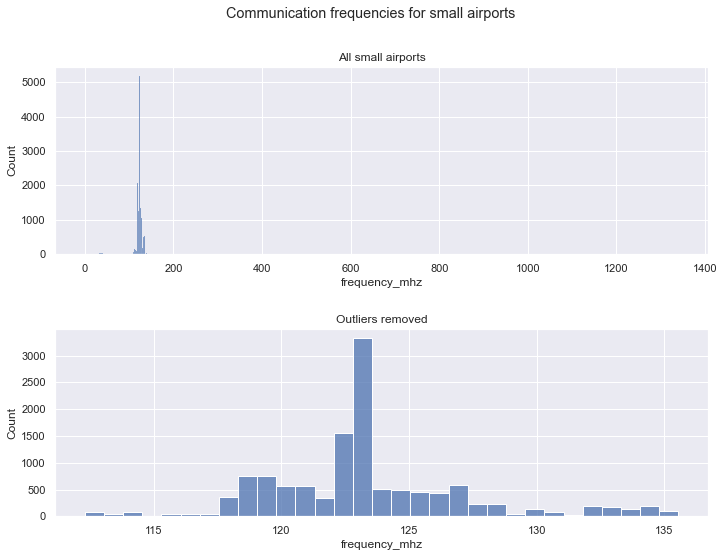

In [88]:
def large_airports_stats():
    """Return descriptive statistics for all large airports."""
    # Filter for large airports only
    df_current_airports.query('type == "large_airport"', inplace = True)
    # Remove all rows with no frequency list i.e. no frequencies
    df_current_airports.dropna(subset=['frequency_mhz'], inplace = True)
    # Create a new dataframe with a row for each frequency item in each list
    df_exploded_frequencies = df_current_airports['frequency_mhz'].explode()
    # Get the descriptive statistics 
    mean = "{:.2f}".format(df_exploded_frequencies.mean())
    median = "{:.2f}".format(df_exploded_frequencies.median())
    mode = "{:.2f}".format(df_exploded_frequencies.mode().iat[0])
    data = ("Large airports", mean, median, mode)
    return data


def high_freq_stats():
    """Return descriptive statistics for all airports with a frequency over 100 mhz."""
    # Remove all rows with no frequency list i.e. no frequencies
    df_current_airports.dropna(subset=['frequency_mhz'], inplace = True)
    # Create a new dataframe with a row for each frequency item in each list
    df_exploded_frequencies = df_current_airports['frequency_mhz'].explode()
    # Remove all frequencies under 100 mhz
    df_exploded_frequencies = df_exploded_frequencies[df_exploded_frequencies > 100]
    # Get the descriptive statistics 
    mean = "{:.2f}".format(df_exploded_frequencies.mean())
    median = "{:.2f}".format(df_exploded_frequencies.median())
    mode = "{:.2f}".format(df_exploded_frequencies.mode().iat[0])
    data = ("Frequencies > 100 MHz", mean, median, mode)
    return data


def small_airport_frequencies():
    """Return descriptive statistics for all large airports."""
    # Filter for small airports only
    df_current_airports.query('type == "small_airport"', inplace = True)
    # Remove all rows with no frequency list i.e. no frequencies
    df_current_airports.dropna(subset=['frequency_mhz'], inplace = True)
    # Create a new dataframe with a row for each frequency item in each list
    exploded_frequencies_series = df_current_airports['frequency_mhz'].explode()
    df_exploded_frequencies = exploded_frequencies_series.to_frame()
    # calculate upper and lower quantiles at 2.5% 
    q_low = df_exploded_frequencies['frequency_mhz'].quantile(0.025)
    q_hi  = df_exploded_frequencies['frequency_mhz'].quantile(0.975)
    # filter the date frame for values inside the upper and lower bounds
    df_outliers_removed = df_exploded_frequencies[(df_exploded_frequencies['frequency_mhz'] < q_hi) & (df_exploded_frequencies['frequency_mhz'] > q_low)]  
    # set Seaborn theme and figure size 
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    # Create a figure for the two graphs with one column of two graphs
    fig = plt.figure(figsize=(20,5))
    fig, axes = plt.subplots(2, 1)
    # Add titles and subplots
    fig.suptitle('Communication frequencies for small airports')
    sns.histplot(ax=axes[0], data = df_exploded_frequencies, x = 'frequency_mhz', binwidth=2)
    axes[0].set_title("All small airports")
    sns.histplot(ax=axes[1], data = df_outliers_removed,x = 'frequency_mhz', binwidth=0.75)
    axes[1].set_title("Outliers removed")
    # Increase vertical spacing
    plt.subplots_adjust(hspace=0.4)


GUI data output tab functions

In [10]:
def check_current_data():
    """Check if data is currently loaded or uploaded into the application."""
    if (len(current_airports) == 0 and len(current_runways) == 0):
        messagebox.showwarning("Error", "No data is loaded into the application. Please visit the 'Manage data' tab")
        return False
    else:
        return True

def display_stats():
    """If there is data in the application display the descriptive statistics frame."""
    if check_current_data() == True:
        add_data_table()
    else: 
        return 

def display_small_airport_frequencies():
    """If there is data in the application display the small airports plot frame."""
    if check_current_data() == True:
        add_small_airport_frequencies()
    else: 
        return 

def display_all_airport_frequencies():
    """If there is data in the application display the airport frequency comparison plot frame."""
    if check_current_data() == True:
        add_all_frequencies()
    else: 
        return 


GUI data output tab

In [12]:
# Create an instance of a tkinter frame and set the size of the window
root = tk.Tk()
root.title('Airport data visualisation application')
root.geometry("800x600")
root.configure(bg="white")

# Create an instance of ttk style
s = ttk.Style()
s.theme_use('default')
s.configure('TNotebook.Tab', background="white")
s.map("TNotebook", background= [("selected", "white")])

# Create and pack a Notebook widget
tabs = ttk.Notebook(root)
tabs.pack(expand= True)

# Create and pack tabs
tab1 = tk.Frame(tabs, width=800, height=600, padx=10, pady=10)
tab2 = tk.Frame(tabs, width=800, height=600, padx=10, pady=10)
tab3 = tk.Frame(tabs, width=800, height=600, padx=10, pady=10)     
tab1.pack(fill="both", expand=1)
tab2.pack(fill="both", expand=1)
tab3.pack(fill="both", expand=1)
                  
# Add tab names
tabs.add(tab1, text="Manage data")
tabs.add(tab2, text="Data outputs")
tabs.add(tab3, text="Help")

# Add buttons and labels to tab1 (Manage data)
uploadTitle = tk.Label(tab1, text="Upload new data", font=("Helvetica", 18), justify="left").place(x=10, y=20)
uploadDataBtn = tk.Button(tab1, text="Upload data", command=gui_upload, width = 15).place(x=10, y=65)
loadTitle = tk.Label(tab1, text="Load previously saved data", font=("Helvetica", 18), justify="left").place(x=10, y=150)
loadSavedDataBtn = tk.Button(tab1, text="Load saved data", command=gui_load, width = 15).place(x=10, y=195)
saveTitle = tk.Label(tab1, text="Save current data", font=("Helvetica", 18), justify="left").place(x=10, y=280)
saveCurrentDataBtn = tk.Button(tab1, text="Save current data", command=gui_save, width = 15).place(x=10, y=325)

# Functions to display the tool tips 
def show_tip1():
    """Show tooltip 1. Hide other tool tips."""
    toolTipText1.place(x=250, y=50)
    toolTipText2.place_forget()
    toolTipText3.place_forget()

def show_tip2():
    """Show tooltip 2. Hide other tool tips."""
    toolTipText2.place(x=250, y=197)
    toolTipText1.place_forget()
    toolTipText3.place_forget()

def show_tip3():
    """Show tooltip 3. Hide other tool tips."""
    toolTipText3.place(x=250, y=319)
    toolTipText1.place_forget()
    toolTipText2.place_forget()

# Add tool tip buttons
toolTipBtn1 = tk.Button(tab1, text="?", command=show_tip1).place(x=185, y=65)
toolTipBtn2 = tk.Button(tab1, text="?", command=show_tip2).place(x=185, y=195)
toolTipBtn3 = tk.Button(tab1, text="?", command=show_tip3).place(x=185, y=325)

# Add tool tip text objects 
toolTipText1 = tk.Label(tab1, text="This feature uploads new data to the application. Files must be correctly named, stored in the 'data' folder and saved in csv format. Files must have the correct column headings.", font=("Helvetica", 15), wraplength=500, justify="left", fg="grey")
toolTipText2 = tk.Label(tab1, text="This feature loads the dataset that was last saved in the application.", font=("Helvetica", 15), wraplength=500, justify="left", fg="grey")
toolTipText3 = tk.Label(tab1, text="This feature saves the current data for future use in the application. This overwrites any currently saved data.", font=("Helvetica", 15), wraplength=500, justify="left", fg="grey")

# Add instructions to Help tab
helpTitle1 = tk.Label(tab3, text="Managing data", font=("Helvetica", 18), justify="left").place(x=10, y=20)
helpSubtitle1 = tk.Label(tab3, text="Uploading new data:", font=("Helvetica", 16), justify="left").place(x=10, y=55)
helpText1 = tk.Label(tab3, text="From the Manage data tab, please click the Upload data button. Files must be correctly named as 'airport-frequencies.csv', 'airports.csv', and 'runways.csv'. Files must be stored in the 'data' folder and saved in csv format. Files must have the correct column headings.", font=("Helvetica", 15), wraplength=740, justify="left").place(x=10, y=90)
helpSubtitle2 = tk.Label(tab3, text="Loading previously saved data:", font=("Helvetica", 16), justify="left").place(x=10, y=165)
helpText2 = tk.Label(tab3, text="From the Manage data tab, please click the Load saved data button. This will load the previously saved data into the application.", font=("Helvetica", 15), wraplength=740, justify="left").place(x=10, y=200)
helpSubtitle3 = tk.Label(tab3, text="Saving current data:", font=("Helvetica", 16), justify="left").place(x=10, y=260)
helpText3 = tk.Label(tab3, text="From the Manage data tab, please click the Save current data button. This will save the current data for future use in the application.", font=("Helvetica", 15), wraplength=740, justify="left").place(x=10, y=295)
helpTitle2 = tk.Label(tab3, text="Data outputs", font=("Helvetica", 18), justify="left").place(x=10, y=360)
helpText4 = tk.Label(tab3, text="Use the three buttons at the top of the tab to select the descriptive statistics or plots that you want to view.", font=("Helvetica", 15), wraplength=740, justify="left").place(x=10, y=395)

# Add output option buttons
statsBtn = tk.Button(tab2, text ="Descriptive statistics", command = display_stats, width = 20).place(x=20, y=50)
smallFreqBtn = tk.Button(tab2, text ="Small frequencies plot", command = display_small_airport_frequencies, width = 20).place(x=275, y=50)
allFreqBtn = tk.Button(tab2, text ="Communication frequencies", command = display_all_airport_frequencies, width = 20).place(x=530, y=50)

# Create frames for the three data output options
statsFrame = tk.Frame(tab2, width=780, height=400)
smallFreqsFrame = tk.Frame(tab2, width=780, height=400)
allFreqsFrame = tk.Frame(tab2, width=680, height=400)

# Stats frame content
statsTitle = tk.Label(statsFrame, text="Global airport communications frequencies:", font=("Helvetica", 18), justify="left")
statsTableFrame = tk.Frame(statsFrame, width=780, height=400)
statsText = tk.Label(statsFrame, text="The descriptive statistics encompase all currently open global airports. Airports without listed communications frequencies and closed airports are not included in the descriptive statistics.\n\nRow 1 includes all airports classified as large.\nRow 2 includes all frequencies from any sized open airport over 100 MHz.", font=("Helvetica", 15), wraplength=740, justify="left")

# Add small airports frequencies plot
testText = tk.Label(smallFreqsFrame, text="This is some text - small airports", font=("Helvetica", 15), wraplength=740, justify="left").place(x=10, y=90)


testTextAgain = tk.Label(allFreqsFrame, text="This is some more text - all airports", font=("Helvetica", 15), wraplength=740, justify="left").place(x=10, y=90)

# Class to create a table
class Table:
    def __init__(self,root, lst):
        # create the descriptive stats table structure
        for i in range(3):
            for j in range(4):
                # Style col 1
                if j == 0:
                    self.e = tk.Entry(root, width=20,
                                font=('Helvetica',15,'bold'))
                    self.e.grid(row=i, column=j)
                    self.e.insert(tk.END, lst[i][j])
                # Style row 1
                elif j > 0 and i == 0:
                    self.e = tk.Entry(root, width=15,
                                font=('Helvetica',15,'bold'), justify='center')
                    self.e.grid(row=i, column=j)
                    self.e.insert(tk.END, lst[i][j])
                # Style the rest of the table
                else:
                    self.e = tk.Entry(root, width=15,
                                font=('Helvetica',15), justify='center')
                    self.e.grid(row=i, column=j)
                    self.e.insert(tk.END, lst[i][j])

def add_data_table():
    """Display the descriptive statistics data table and associated text."""
    # get the data for the descriptive statistics table
    lst = [(" ", "Mean MHz", "Median MHz", "Mode MHz" ),large_airports_stats(),high_freq_stats()]
    # create the table using the Table class
    table = Table(statsTableFrame, lst)
    # place stats widgets 
    statsTitle.place(x=10, y=10)
    statsTableFrame.place(x=10, y=55)
    statsText.place(x=10, y=160)
    statsFrame.place(x=10, y=90)
    # remove non-stats widgets  
    smallFreqsFrame.place_forget()
    allFreqsFrame.place_forget()

def add_small_airport_frequencies():
    statsFrame.place_forget()
    allFreqsFrame.place_forget()
    smallFreqsFrame.place(x=10, y=90)

def add_all_frequencies():
    statsFrame.place_forget()
    smallFreqsFrame.place_forget()
    allFreqsFrame.place(x=10, y=90)

root.mainloop()